In [ ]:
## 2 ways to improve the performance
# yolov2 : changes in model configurations
# yolo9000 : changes in model training method. joint training of classification and object detection.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import random

from global_utils import IoU
import torch

## Anchor Boxes

### k-mean clustering

In [90]:
## https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670

def KmeanClustering(bboxes, max_iters, k = 5, plot = True) :
    '''
    read out whole bounding boxes from train datasets, and perform k mean clusterings
    bboxes = (x_center, y_center, w, h). Here ratios are respect to the image size, NOT grid cell.
    max_iters : number of maximum iterations
    k : number of clusters
    '''
    

    # initialize the centroid
    min_w, min_h = np.min(bboxes[:,2]), np.min(bboxes[:,3])
    max_w, max_h = np.max(bboxes[:,2]), np.max(bboxes[:,3])
    # uniformly distribute the k cluster centroids
    centroids = np.array([[np.random.uniform(min_w, max_w), np.random.uniform(min_h, max_h)] for i in range(k)])
    
    prev_centroids = None
    iteration = 0

    print('initial centroids : ', centroids)
    if plot :
        plt.scatter(bboxes[:,2], bboxes[:,3])
        plt.title('original points')
        plt.show()

    while np.not_equal(centroids, prev_centroids).any() or iteration < max_iters :
        
        sorted_points = [[] for _ in range(k)]

        for (_, _, w, h) in bboxes :
            
            # Suppose x_center and y_center are same for centroid and data point here, we just want the ratio of w, h.
            x, y = 0.5, 0.5

            dist = np.array([IoU(torch.tensor([x, y, w, h]), 
                                 torch.tensor([x, y, centroid_w, centroid_h ])) 
                                 for centroid_w, centroid_h in centroids]) # IoU supports only torch for now
            centroid_idx = np.argmax(dist)
            sorted_points[centroid_idx].append([w, h])

        prev_centroids = centroids
        centroids = [[np.mean([c[0] for c in cluster]), np.mean([c[1] for c in cluster])] for cluster in sorted_points ]

    if plot :
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                    for i in range(k)]

        for i, cluster in enumerate(sorted_points) :
            if len(cluster) :
                plt.scatter(np.array(cluster)[:,0], np.array(cluster)[:, 1], color = color[i])
        plt.title('after clustering')
        plt.show()

        # if any new centroids has NaN, then substitute back to previous centroids
        # centroids[np.isnan(centroids)] = prev_centroids[np.isnan(centroids)]

        iteration += 1

    return centroids



In [85]:
def read_json_info(jsonfile) :
    with open(jsonfile, 'r') as f :
        json_infos = json.load(f)

    total_bboxes = []
    for js_info in tqdm(json_infos) :
        img_h, img_w = js_info['imgsize']
        label_info = js_info['labels'] if 'labels' in js_info.keys() else []
        for idx in range(len(label_info)) :
            label = label_info[idx]['category']
            coord = label_info[idx]['box2d']

            x,y,w,h = coord['x'], coord['y'], coord['w'], coord['h']
            total_bboxes.append([x, y, w, h])

    return total_bboxes
            


In [86]:
## Test Case

bboxes = read_json_info(jsonfile = 'data/label/yolo_det_val.json')



100%|██████████| 10000/10000 [00:00<00:00, 54097.64it/s]


initial centroids :  [[0.11339715 0.02097848]
 [0.34259652 0.19360561]
 [0.29019374 0.43973265]
 [0.35291663 0.87103131]
 [0.32545784 0.60087609]]


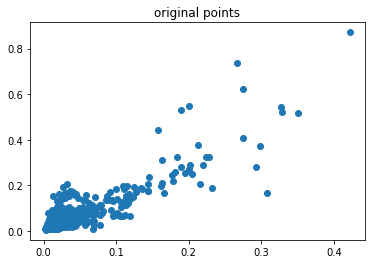

/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_4465/3694228162.py:36: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  dist = np.array([IoU(torch.tensor([x, y, w, h]),
/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_4465/3694228162.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dist = np.array([IoU(torch.tensor([x, y, w, h]),


KeyboardInterrupt: 

In [91]:
centroids = KmeanClustering(np.array(bboxes)[:500], max_iters = 10, k = 5)

In [ ]:
[[[1,2]]]

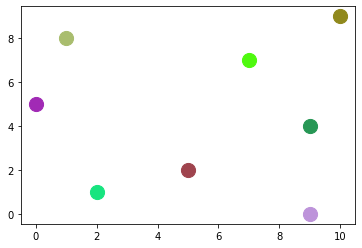

In [53]:
## visualize ratio box
import matplotlib.pyplot as plt
import random

number_of_colors = 8

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


for i in range(number_of_colors):
    plt.scatter(random.randint(0, 10), random.randint(0,10), c=color[i], s=200)

plt.show()

#### batch normalization

In [80]:
''' 
reference : https://github.com/rafaelpadilla/Object-Detection-Metrics
usage : validation, evaluation. 
predictions and gts will be handed by reading gtfile directly, since dataloader limits the number of gt bounding box
'''


from global_utils import IoU

## MAP

class MeanAveragePrecisionMetrics :
    def __init__(self, gts, preds, iou_threshold_range, confidence_threshold) :
        '''
        gts, preds = [[[class, x, y, w, h, c],...], ...] # imgs x bboxes

        classes : should be collected from gt.
        iou_threshold_range : (min_threshold, interval, max_threshold). e.g) IoU(0.6, 0.1, 0.9) = [0.6, 0.7, 0.8, 0.9]
        confidence_threshold : predicted bounding boxes are filtered by confidence threshold
        '''
        self.gts = gts
        self.preds = preds
        assert len(gts) == len(preds), '# of images should be the same for predictions and ground truths.'
        
        cnt_cls = set()
        for gts_per_img in self.gts :
            for gt_bbox in gts_per_img :
                cnt_cls.add(int(gt_bbox[0]))
        self.classes = list(cnt_cls)

        # convert iou_threshold_range into list
        min_threshold, interval, max_threshold  = iou_threshold_range
        self.iou_threshold_range = np.linspace(min_threshold, max_threshold, num= int((max_threshold - min_threshold)//interval + 1))
        
        self.confidence_threshold = confidence_threshold
        self.iou_table_per_img = {imgidx : None for imgidx in range(len(gts))}

        # self.total_iou_table = {clslabel : {iou_threshold : None \
        #                                         for iou_threshold in self.iou_threshold_range} \
        #                                             for clslabel in range(num_classes)}

        self.TOTAL_TP = [{iou_threshold : 0 for iou_threshold in self.iou_threshold_range} for _ in range(len(self.classes))]
        self.TOTAL_FP = [{iou_threshold : 0 for iou_threshold in self.iou_threshold_range} for _ in range(len(self.classes))]
        self.TOTAL_FN = [{iou_threshold : 0 for iou_threshold in self.iou_threshold_range} for _ in range(len(self.classes))]

        self.total_statistics = []


    def calculate_PR(self, imgidx, pred, gt, iou_threshold) :
        '''
        calculate precision and recall per classes
        Recall = TP / (TP+FN)
        Precision = TP / (TP + FP)
        1. match preds and gts using IoU
        2. matched preds will be TP, and remaining unmatched preds will be FP, and unmatched gt are FN.
        '''

        # bboxes = [[class,x,y,w,h,c],...]. c = confidence_score. filter predicted bboxes by confidence_threshold.
        
        pred = np.array([p for p in pred if p[-1] > self.confidence_threshold])
        
        
        # 행 : pred, 열 : gt
        if self.iou_table_per_img[imgidx] is not None :
            iou_table = self.iou_table_per_img[imgidx]
        else : 
            iou_table = torch.zeros((len(pred), len(gt)))
            for j, pred_bbox in enumerate(pred) :
                for i, gt_bbox in enumerate(gt) :
                    iou_table[j][i] = IoU(pred_bbox[..., 1:], gt_bbox[..., 1:])
            self.iou_table_per_img[imgidx] = iou_table
        # if there are more than one prediction box matched with on gt box, then we choose the predicition with the highest IoU as TP, and treat other matches as FP.     
        filtered_iou_table = torch.zeros_like(iou_table)
        filtered_iou_table[torch.argmax(iou_table, axis = 0), torch.arange(iou_table.shape[1])] = torch.max(iou_table, axis = 0)[0] # this will leave only one highest IoU per gts
        
        result = filtered_iou_table > iou_threshold

        TP = result.any(axis = 1).sum()
        FP = len(pred) - TP
        FN = len(gt) - result.any(axis = 0).sum()

        return TP.item(), FP.item(), FN.item()

    def calculate_average_precision(self, precision, recall) :

        precision = list(precision)[:] # [:] = copy list
        recall = list(recall)[:]

        mean_precision = [0] + precision + [0] 
        mean_recall = [0] + recall + [0]
        """
        This part makes the precision monotonically decreasing
            (goes from the end to the beginning)
        """
        for i in range(len(mean_precision)-2, -1, -1) :
            mean_precision[i] = max(mean_precision[i], mean_precision[i+1])
        
        """
        This part creates a list of indexes where the recall changes
        """
        i_list = []
        for i in range(1, len(mean_recall)) :
            if mean_recall[i] != mean_recall[i-1] :
                i_list.append(i)
        """
        The Average Precision (AP) is the area under the curve
            (numerical integration)
        """
        average_precision = 0.0
        for i in i_list :
            average_precision += ((mean_recall[i] - mean_recall[i-1]) * mean_precision[i])

        # average_precision = torch.mean(torch.trapz(torch.tensor(precision), torch.tensor(recall))).item()
        return average_precision


    def calculate(self) :
        ## TODO : add typing of variables
        '''
        preds : list of numpy array. []
        gts 
        iou_threshold_range : (minimum_threshold, maximum_threshold, interval)
        '''
        for imgidx, (pred_by_img, gt_by_img) in enumerate(zip(self.preds, self.gts)) :
            for cls_label in self.classes :
                cls_preds = pred_by_img[pred_by_img[..., 0] == cls_label]
                cls_gts = gt_by_img[gt_by_img[..., 0] == cls_label]

                # assert (cls_preds.shape == cls_gts.shape) and (cls_preds.ndim == cls_gts.ndim == 2 and cls_preds.shape[-1] == cls_gts.shape[-1] == 5), \
                #             'pred and gt shape = (# of bboxes over images, len([x,y,w,h,c]) )'

                for iou_threshold in self.iou_threshold_range :
                    TP, FP, FN = self.calculate_PR(imgidx, cls_preds, cls_gts, iou_threshold)
                    self.TOTAL_TP[cls_label][iou_threshold] += TP
                    self.TOTAL_FP[cls_label][iou_threshold] += FP
                    self.TOTAL_FN[cls_label][iou_threshold] += FN

        # calculate Precision and Recall

        for cls_label in self.classes :
            for iou_threshold in self.iou_threshold_range :
                ## round by 3 decimal points
                precision = round(self.TOTAL_TP[cls_label][iou_threshold] / (self.TOTAL_TP[cls_label][iou_threshold] + self.TOTAL_FP[cls_label][iou_threshold] + 1e-6), 3) # add 1e-6 to prevent divisionbyzero
                recall = round(self.TOTAL_TP[cls_label][iou_threshold] / (self.TOTAL_TP[cls_label][iou_threshold] + self.TOTAL_FN[cls_label][iou_threshold] + 1e-6), 3)

                self.total_statistics.append([cls_label, iou_threshold, precision, recall])

        self.total_statistics = np.array(self.total_statistics)

        # mean average precision = sum(avg_cls_precision) / num_classes. avg_cls_precision = sum of cls_precisions in different recalls / 
        mean_average_precision = 0
        
        for cls_label in self.classes :
            class_statistics = self.total_statistics[self.total_statistics[..., 0] == cls_label][...,2:4].tolist() # ious x [precision, recall]
            class_statistics = sorted(class_statistics, key = lambda x : x[1])
            precision, recall = zip(*class_statistics)
            
            average_precision = self.calculate_average_precision(precision, recall)
            mean_average_precision += average_precision
            

        mean_average_precision /= len(self.classes)

        return mean_average_precision

    

In [81]:
## read sample and test 
# 00001.txt gt
gt1= ['person 0.22 0.22 0.19 0.28 1',
'person 0.7475 0.77 0.20500000000000002 0.31 1']
# 00001.txt pred
pred1 = ['person .88 0.10250000000000001 0.455 0.155 0.24',
'person .70 0.6950000000000001 0.7225 0.2 0.335',
'person .80 0.7425 0.2125 0.245 0.335',]
# 00002.txt gt
gt2= ['person 0.7225 0.1925 0.215 0.275 1',
'person 0.3375 0.7725 0.295 0.225 1',]
# 00002.txt pred
pred2 = ['person .71 0.48 0.7000000000000001 0.32 0.29',
'person .54 0.28 0.8175 0.3 0.23500000000000001',
'person .74 0.2025 0.1775 0.215 0.17500000000000002',]
# 00003.txt gt
gt3= ['person 0.1675 0.19 0.17500000000000002 0.24 1',
'person 0.7375 0.26 0.245 0.22 1',
'person 0.6125 0.8125 0.23500000000000001 0.23500000000000001 1',]
# 00003.txt pred
pred3 = ['person .18 0.7375 0.17250000000000001 0.385 0.195',
'person .67 0.545 0.4275 0.23 0.225',
'person .38 0.89 0.4425 0.18 0.265',
'person .91 0.6425 0.7725 0.23500000000000001 0.23500000000000001',
'person .44 0.19 0.85 0.2 0.22',]

# 00004.txt gt
gt4= ['person 0.365 0.34 0.2 0.26 1',
'person 0.8475 0.3 0.155 0.17 1',]
# 00004.txt pred
pred4 = ['person .35 0.485 0.20500000000000002 0.14 0.13',
'person .78 0.245 0.5075000000000001 0.21 0.335',
'person .45 0.4975 0.5425 0.125 0.195',
'person .14 0.2 0.84 0.3 0.13',]

# 00005.txt gt
gt5= ['person 0.405 0.28250000000000003 0.22 0.255 1',
'person 0.325 0.77 0.17 0.26 1',]
# 00005.txt pred
pred5 = ['person .62 0.32 0.305 0.14 0.23',
'person .44 0.6075 0.125 0.265 0.14',
'person .95 0.325 0.7275 0.36 0.145',
'person .23 0.325 0.8875000000000001 0.36 0.145',]

# 00006.txt gt
gt6= ['person 0.31 0.635 0.26 0.38 1',
'person 0.42 0.4575 0.22 0.335 1',]
# 00006.txt pred
pred6 = ['person .45 0.4 0.335 0.37 0.19',
'person .84 0.1575 0.8625 0.145 0.17500000000000002',
'person .43 0.5375 0.655 0.125 0.21',]

# 00007.txt gt
gt7= ['person 0.2775 0.3125 0.275 0.315 1',
'person 0.41500000000000004 0.48 0.25 0.29 1',]
# 00007.txt pred
pred7 = ['person .48 0.3325 0.32 0.505 0.44',
'person .95 0.2575 0.7025 0.185 0.245',]





In [82]:
class_dict = {'person' : 0}

def convert_bbox(infos) : 
    bboxes = []
    for info in infos :
        classlabel, x, y, w, h, c = info.split(' ')
        classlabel = class_dict[classlabel]
        x,y,w,h,c =  map(float, [x,y,w,h, c])
        bboxes.append([classlabel, x, y, w, h, c])
    return np.array(bboxes)



In [83]:
gts = [torch.tensor(convert_bbox(g)) for g in [gt1,gt2,gt3,gt4,gt5,gt6,gt7]]
preds = [torch.tensor(convert_bbox(p)) for p in [pred1,pred2,pred3,pred4,pred5,pred6,pred7]]

In [84]:
MAP_metrics = MeanAveragePrecisionMetrics(gts, preds,  iou_threshold_range = (0.2, 0.1, 0.6), confidence_threshold = 0.1)

In [85]:
MAP_metrics.calculate()

C:\Users\user\AppData\Local\Temp\ipykernel_6480\784397417.py:60: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  pred = np.array([p for p in pred if p[-1] > self.confidence_threshold])
C:\Users\user\AppData\Local\Temp\ipykernel_6480\784397417.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred = np.array([p for p in pred if p[-1] > self.confidence_threshold])


0.06926399999999999

In [49]:
MAP_metrics.iou_threshold_range

array([0.2       , 0.33333333, 0.46666667, 0.6       ])

In [72]:
MAP_metrics.total_statistics

array([[0.        , 0.2       , 0.208     , 0.333     ],
       [0.        , 0.33333333, 0.125     , 0.2       ],
       [0.        , 0.46666667, 0.125     , 0.2       ],
       [0.        , 0.6       , 0.042     , 0.067     ]])

In [73]:
(0.042 * 0.067 + 0.125 * 0.133 + 0.208 * 0.133)/3

0.015701000000000003

In [1]:
import torch

In [5]:
a = torch.randn((224,224,3))
b = torch.randn((224,224,3))
c = torch.randn((224,224,3))

ls = [a,b,c]

torch.stack(ls).shape

torch.Size([3, 224, 224, 3])

In [7]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [8]:
mAP = MeanAveragePrecision(box_format="cxcywh",
            iou_type="bbox",
            iou_thresholds=None,)

In [24]:
batch_size = 16

preds = [
    dict(
boxes = torch.randn((batch_size, 4)),
scores = torch.randn((batch_size, 1)),
labels = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(-1,1),
)]
gts = [
    dict(
        boxes = torch.randn((batch_size, 4)),
        scores = torch.randn((batch_size, 1)),
        labels = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(-1,1),
    )
]

mAP.update(preds, gts)

In [25]:
mAP.compute()

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [19]:
 torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]).shape

torch.Size([1, 16])